<a href="https://colab.research.google.com/github/srinivasanibmbangalore/AnalyticsVidhyaCourseOnDL/blob/master/AVidhyaManWoman1_CNN_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import argparse
import os
import shutil
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from psutil import virtual_memory
import tensorflow as tf

from keras import backend as K 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation,InputLayer, Conv2D, MaxPool2D, Flatten
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.layers import GlobalMaxPool2D
import math
 

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/ml_data/avidhya/manvswoman'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
print(tf.__version__)
import distutils
if distutils.version.LooseVersion(tf.__version__) < '1.14':
    raise Exception('This notebook is compatible with TensorFlow 1.14 or higher, for TensorFlow 1.13 or lower please use the previous version at https://github.com/tensorflow/tpu/blob/r1.13/tools/colab/classification_iris_data_with_keras.ipynb')

2.2.0


In [6]:
use_tpu = True #@param {type:"boolean"}

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TF_MASTER=''

In [7]:
# Model specific parameters

# TPU address
tpu_address = TF_MASTER

# Number of epochs
epochs = 50

# Number of steps_per_epoch
steps_per_epoch = 5

# NOTE: Total number of training steps = Number of epochs * Number of steps_per_epochs

In [8]:
print(tpu_address)

grpc://10.91.244.82:8470


In [9]:
pwd='4/2QGDxWflA3zX7ZXBypH0jbuI6FDr8FtC_3kF3RYmRjZDaOFgSwQeIoU'

train_path=root_path+'/train'
test_path=root_path+'/test'
images_path=root_path+'/images'
output_path=root_path+'/output'

In [ ]:
def move_files(abs_dirname):
    """Move files into subdirectories."""

    files = [os.path.join(abs_dirname, f) for f in os.listdir(abs_dirname)]

    i = 0
    curr_subdir = None

    for f in files:
        # create new subdir if necessary
        if i % N == 0:
            subdir_name = os.path.join(abs_dirname, '{0:03d}'.format(i / N + 1))
            os.mkdir(subdir_name)
            curr_subdir = subdir_name

        # move file to current dir
        f_base = os.path.basename(f)
        shutil.move(f, os.path.join(subdir_name, f_base))
        i += 1

In [ ]:
move_files(train_path+'/images')

In [10]:
!pwd


/content


In [11]:
os.chdir(root_path+'/images')

In [ ]:
#!unzip image.zip


In [12]:
!ls

001  038  075  112  149  186  223  260	297  334  371  408  445  482  519  556
002  039  076  113  150  187  224  261	298  335  372  409  446  483  520  557
003  040  077  114  151  188  225  262	299  336  373  410  447  484  521  558
004  041  078  115  152  189  226  263	300  337  374  411  448  485  522  559
005  042  079  116  153  190  227  264	301  338  375  412  449  486  523  560
006  043  080  117  154  191  228  265	302  339  376  413  450  487  524  561
007  044  081  118  155  192  229  266	303  340  377  414  451  488  525  562
008  045  082  119  156  193  230  267	304  341  378  415  452  489  526  563
009  046  083  120  157  194  231  268	305  342  379  416  453  490  527  564
010  047  084  121  158  195  232  269	306  343  380  417  454  491  528  565
011  048  085  122  159  196  233  270	307  344  381  418  455  492  529  566
012  049  086  123  160  197  234  271	308  345  382  419  456  493  530  567
013  050  087  124  161  198  235  272	309  346  383  420  457  

In [13]:
import os
num_files=0
clmn_names=['image_name','imgDirLocation']
imgDF = pd.DataFrame(columns=clmn_names)
imgDF.describe()


,image_name,imgDirLocation
count,0,0
unique,0,0
top,NaN,NaN
freq,NaN,NaN


In [14]:
%%time
i=0
for root, dirs, files in tqdm(os.walk(images_path, topdown=False)):
   for name in files:
      _, ext = os.path.splitext(name)
      if (ext == '.jpg'):
          imgDF.loc[i]=[name,root]
          i+=1
    

582it [00:56, 10.35it/s]

CPU times: user 55.2 s, sys: 420 ms, total: 55.6 s
Wall time: 56.3 s


In [15]:
used_ramgb=virtual_memory().available/1e9
print("Available Memory is " + str(used_ramgb) + " gb")

Available Memory is 12.592316416 gb


In [16]:
imgDF.describe()

,image_name,imgDirLocation
count,17423,17423
unique,17423,581
top,23201.jpg,/content/gdrive/My Drive/ml_data/avidhya/manvs...
freq,1,30


In [17]:
imgDF.head()

,image_name,imgDirLocation
0,21117.jpg,/content/gdrive/My Drive/ml_data/avidhya/manvs...
1,14812.jpg,/content/gdrive/My Drive/ml_data/avidhya/manvs...
2,25198.jpg,/content/gdrive/My Drive/ml_data/avidhya/manvs...
3,5684.jpg,/content/gdrive/My Drive/ml_data/avidhya/manvs...
4,2464.jpg,/content/gdrive/My Drive/ml_data/avidhya/manvs...


In [18]:
seed = 42
rng = np.random.RandomState(seed)
tr_data = pd.read_csv(root_path+'/train.csv')

tr_data.describe()

,class
count,12196.000000
mean,0.506232
std,0.499982
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [19]:
tr_data.head()

,image_names,class
0,11413.jpg,1
1,9863.jpg,1
2,997.jpg,0
3,5950.jpg,0
4,10454.jpg,1


/content/gdrive/My Drive/ml_data/avidhya/manvswoman/images/005/9257.jpg


(224, 224, 3)

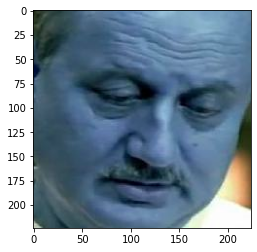

In [20]:
trialImgLoc=imgDF.imgDirLocation[4]+'/'+imgDF.image_name[16]
print(trialImgLoc)
img=cv2.imread(trialImgLoc)
plt.imshow(img)
img.shape

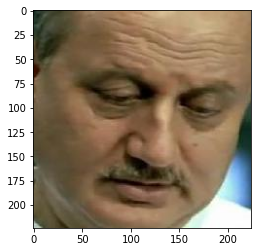

In [21]:
im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb)

Available Memory is 12.591947776 gb


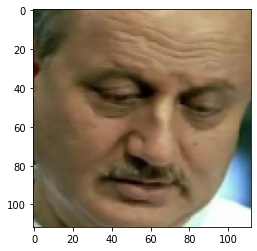

In [22]:
resized_im_rgb=cv2.resize(im_rgb,(112,112))
plt.imshow(resized_im_rgb)
resized_im_rgb.shape

used_ramgb=virtual_memory().available/1e9
print("Available Memory is " + str(used_ramgb) + " gb")

In [23]:
used_ramgb=virtual_memory().available/1e9
print("Available Memory is " + str(used_ramgb) + " gb")

Available Memory is 12.59051008 gb


In [24]:
%%time
X = []
i=0
for img_name in tqdm(tr_data.image_names):
    dir=imgDF.loc[imgDF['image_name']== img_name,'imgDirLocation'].iloc[0]
    path=dir+'/'+img_name
    #print(dir)
    #img = plt.imread(path)
    img=cv2.imread(path)
    img_resized=cv2.resize(img,(112,112))
    X.append(img_resized)
    #print(str(i)+". "+path)
    i+=1
X_a=np.array(X)
X_a.shape
used_ramgb=virtual_memory().available/1e9
print("Available Memory is " + str(used_ramgb) + " gb")

100%|██████████| 12196/12196 [01:27<00:00, 139.07it/s]


Available Memory is 11.607425024 gb
CPU times: user 41 s, sys: 6.89 s, total: 47.9 s
Wall time: 1min 27s


In [25]:
Y_a=tr_data['class'].to_numpy()
Y_a.shape


(12196,)

In [26]:
img_width, img_height = 112, 112
if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3)
print(input_shape)

(112, 112, 3)


In [27]:
X_train, X_valid, y_train, y_valid=train_test_split(X_a,Y_a,test_size=0.3, random_state=seed)


In [28]:
used_ramgb=virtual_memory().available/1e9
print("Available Memory is " + str(used_ramgb) + " gb")

Available Memory is 11.143733248 gb


In [29]:
del X_a


In [30]:
used_ramgb=virtual_memory().available/1e9
print("Available Memory is " + str(used_ramgb) + " gb")

Available Memory is 11.600461824 gb


In [31]:
X_train.shape
X_valid.shape
y_train.shape
y_valid.shape

(3659,)

In [32]:
y_valid.shape

(3659,)

In [33]:
y_valid=np.expand_dims(y_valid,axis=1)
y_valid.shape

(3659, 1)

In [42]:
X_train.shape[0]

8537

In [43]:
y_valid.shape[0]

3659

In [34]:
y_train=np.expand_dims(y_train,axis=1)
y_train.shape

(8537, 1)

In [35]:
used_ramgb=virtual_memory().available/1e9
print("Available Memory is " + str(used_ramgb) + " gb")

#X_train = np.reshape(X_train,(-1,112*112*3))
#X_valid = np.reshape(X_valid,(-1,112*112*3))

#used_ramgb=virtual_memory().available/1e9
#print("Available Memory is " + str(used_ramgb) + " gb")

X_train = X_train.astype('float16')
X_valid = X_valid.astype('float16')

# Normalization of pixel values (to [0-1] range)

X_train /= 255
X_valid /= 255

used_ramgb=virtual_memory().available/1e9
print("Available Memory is " + str(used_ramgb) + " gb")

Available Memory is 11.601498112 gb
Available Memory is 11.416379392 gb


In [36]:
X_train.shape

(8537, 112, 112, 3)

In [33]:
%%time
model = Sequential()
    
model.add(InputLayer(input_shape=(112, 112, 3)))

model.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='valid'))
model.add(Conv2D(50, (5, 5), activation='relu', strides=(1, 1), padding='valid'))

model.add(Flatten())

model.add(Dense(units=100, activation='sigmoid'))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 108, 108, 25)      1900      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 104, 104, 50)      31300     
_________________________________________________________________
flatten_2 (Flatten)          (None, 540800)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               54080100  
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 54,113,401
Trainable params: 54,113,401
Non-trainable params: 0
_________________________________________________________________
CPU times: user 886 ms, sys: 636 ms, total: 1.52 s
Wall time: 832 ms


In [47]:
#check the available memory.

 
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:

    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')

    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')

    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

used_ramgb=virtual_memory().available/1e9
print("Available Memory is " + str(used_ramgb) + " gb")

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.
Available Memory is 10.91659776 gb


###To make the model usable by a TPU, we first must create and compile it using a distribution strategy.

In [37]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TF_MASTER)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.91.244.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.91.244.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [38]:
BATCH_SIZE=64*strategy.num_replicas_in_sync
LEARNING_RATE=0.01
LEARNING_RATE_EXP_DECAY=0.6 if strategy.num_replicas_in_sync == 1 else 0.7
# Learning rate computed later as LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch
# 0.7 decay instead of 0.6 means a slower decay, i.e. a faster learnign rate.



In [39]:
with strategy.scope():
    model = Sequential()
    model.add(InputLayer(input_shape=(112, 112, 3)))
    model.add(Conv2D(50, (5, 5), activation='relu', strides=(1, 1), padding='valid'))
    model.add(Conv2D(100, (5, 5), activation='relu', strides=(1, 1), padding='valid'))
    model.add(Flatten())
    model.add(Dense(units=100, activation='sigmoid'))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()
lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 108, 108, 50)      3800      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 104, 104, 100)     125100    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1081600)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               108160100 
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 108,289,101
Trainable params: 108,289,101
Non-trainable params: 0
_________________________________________________________________


In [35]:
#model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

###Obvious that due to input image array reshaping and considering high dimensional image size, the consumed memory is quite high

In [50]:
%%time

#history = model.fit(X_train,y_train, steps_per_epoch = steps_per_epoch,epochs=epochs,  validation_data=(X_valid,y_valid))
epochs=15
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / 32))
print(BATCH_SIZE)
#steps_per_epoch = 8537//BATCH_SIZE  # 8537 items in this dataset
steps_per_epoch = compute_steps_per_epoch(X_train.shape[0])
val_steps = compute_steps_per_epoch(X_valid.shape[0])

history = model.fit(X_train,y_train,epochs=epochs,steps_per_epoch=steps_per_epoch, validation_steps=val_steps, validation_data=(X_valid,y_valid))
#history = model.fit(X_train,y_train,epochs=epochs, validation_data=(X_valid,y_valid))
#model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid,Y_valid))

512
Train on 8537 samples, validate on 3659 samples
Epoch 1/15


InvalidArgumentError: ignored

In [37]:
used_ramgb=virtual_memory().available/1e9
print("Available Memory is " + str(used_ramgb) + " gb")

Available Memory is 11.191025664 gb


In [38]:
def plotLosses(history):  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

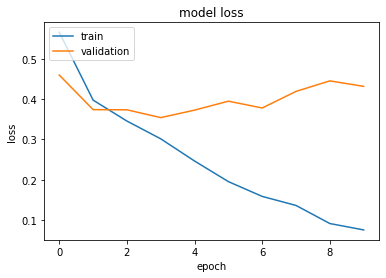

In [39]:
plotLosses(history)

In [40]:
score = model.evaluate(X_valid, y_valid, batch_size=128, verbose=0)
print(model.metrics_names)
print(score)

['loss', 'accuracy']
[0.43155909496827605, 0.8395736813545227]


In [41]:
tst_data=pd.read_csv(root_path+'/test_fkwGUNG.csv')
tst_data.describe()

,image_names
count,5227
unique,5227
top,8555.jpg
freq,1


In [42]:

%%time
X=[]
path=""
dir=""
for img_name in tqdm(tst_data.image_names):
    dir=imgDF.loc[imgDF['image_name']== img_name,'imgDirLocation'].iloc[0]
    path=dir+'/'+img_name
    #print(dir)
    #img = plt.imread(path)
    img=cv2.imread(path)
    img_resized=cv2.resize(img,(112,112))
    img_resized=img_resized.astype('float16')
    img_resized=img_resized/255
    X.append(img_resized)
    #print(str(i)+". "+path)
    i+=1
X_a=np.array(X)
X_a.shape
used_ramgb=virtual_memory().available/1e9
print("Available Memory is " + str(used_ramgb) + " gb")

100%|██████████| 5227/5227 [22:26<00:00,  3.88it/s]

Available Memory is 11.666284544 gb
CPU times: user 34.7 s, sys: 4.77 s, total: 39.4 s
Wall time: 22min 26s


In [43]:
#X_a = np.reshape(X_a,(-1,112*112*3))
%%time
prediction = model.predict_classes(X_a)

CPU times: user 3min 57s, sys: 744 ms, total: 3min 57s
Wall time: 2min 4s


In [50]:
!!cat /proc/cpuinfo

['processor\t: 0',
 'vendor_id\t: GenuineIntel',
 'cpu family\t: 6',
 'model\t\t: 63',
 'model name\t: Intel(R) Xeon(R) CPU @ 2.30GHz',
 'stepping\t: 0',
 'microcode\t: 0x1',
 'cpu MHz\t\t: 2300.000',
 'cache size\t: 46080 KB',
 'physical id\t: 0',
 'siblings\t: 2',
 'core id\t\t: 0',
 'cpu cores\t: 1',
 'apicid\t\t: 0',
 'initial apicid\t: 0',
 'fpu\t\t: yes',
 'fpu_exception\t: yes',
 'cpuid level\t: 13',
 'wp\t\t: yes',
 'flags\t\t: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities',
 'bugs\t\t: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs',
 'bogomips\t: 4600.00',
 

In [45]:
prediction.shape

(5227, 1)

In [46]:
clmn_names_op=['image_name','prediction']
dfOutput = pd.DataFrame(columns=clmn_names_op)
dfOutput.describe()


,image_name,prediction
count,0,0
unique,0,0
top,NaN,NaN
freq,NaN,NaN


In [47]:
dfOutput['image_name']=tst_data['image_names']
dfOutput['prediction']=prediction
dfOutput.head()
with open(output_path+'/manvswoman_onehiddenlayer_cnn1.csv', 'w') as f:
  dfOutput.to_csv(f)



#### increase number of convolutional layers
#### increase number of pooling layers
#### increase number of convolutional filters
#### change size of conv
#### change size of pooling
#### change padding technique
#### change stride

In [48]:
# Increase the number of layers
model = Sequential()
    
model.add(InputLayer(input_shape=(112, 112, 3)))

model.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='valid'))
model.add(Conv2D(50, (5, 5), activation='relu', strides=(1, 1), padding='valid'))
model.add(MaxPool2D(pool_size=(4, 4), padding='valid'))

model.add(Conv2D(100, (5, 5), activation='relu', strides=(1, 1), padding='valid'))
model.add(MaxPool2D(pool_size=(4, 4), padding='valid'))

model.add(Flatten())

model.add(Dense(units=100, activation='sigmoid'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 108, 108, 25)      1900      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 104, 104, 50)      31300     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 50)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 22, 100)       125100    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 100)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)              

In [49]:
%%time
history = model.fit(X_train,y_train, epochs=10,  validation_data=(X_valid,y_valid))

Train on 8537 samples, validate on 3659 samples
Epoch 1/10
8537/8537 [==============================] - 879s 103ms/step - loss: 0.5800 - accuracy: 0.6625 - val_loss: 0.4323 - val_accuracy: 0.7967
Epoch 2/10
8537/8537 [==============================] - 835s 98ms/step - loss: 0.4016 - accuracy: 0.8182 - val_loss: 0.3494 - val_accuracy: 0.8453
Epoch 3/10
8537/8537 [==============================] - 845s 99ms/step - loss: 0.3370 - accuracy: 0.8517 - val_loss: 0.3043 - val_accuracy: 0.8675
Epoch 4/10
8537/8537 [==============================] - 841s 98ms/step - loss: 0.2904 - accuracy: 0.8714 - val_loss: 0.2882 - val_accuracy: 0.8781
Epoch 5/10
8537/8537 [==============================] - 876s 103ms/step - loss: 0.2578 - accuracy: 0.8907 - val_loss: 0.2722 - val_accuracy: 0.8858
Epoch 6/10
8537/8537 [==============================] - 890s 104ms/step - loss: 0.2314 - accuracy: 0.9049 - val_loss: 0.2540 - val_accuracy: 0.8964
Epoch 7/10
8537/8537 [==============================] - 889s 104ms/

In [52]:
from keras.layers import GlobalMaxPool2D

In [54]:
# change filter size for convolutional layer and pooling size for pooling layer
model = Sequential()
    
model.add(InputLayer(input_shape=(112, 112, 3)))

model.add(Conv2D(125, (5, 5), activation='relu', strides=(1, 1), padding='valid'))
model.add(Conv2D(150, (5, 5), activation='relu', strides=(1, 1), padding='valid'))
model.add(MaxPool2D(pool_size=(8, 8), padding='valid'))

model.add(Conv2D(200, (3, 3), activation='relu', strides=(1, 1), padding='valid'))
model.add(Conv2D(225, (3, 3), activation='relu', strides=(1, 1), padding='valid'))

model.add(GlobalMaxPool2D())

model.add(Dense(units=100, activation='sigmoid'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 108, 108, 125)     9500      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 104, 104, 150)     468900    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 150)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 11, 11, 200)       270200    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 9, 9, 225)         405225    
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 225)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)              

In [ ]:
%%time
history = model.fit(X_train,y_train, epochs=10,  validation_data=(X_valid,y_valid))

#Hyper Parameter Tuning
###### change activation function of hidden layer
###### increase hidden neurons
###### increase hidden layers
###### increase number of epochs
###### change optimizer

#### Change the activation function

In [ ]:
model = Sequential()
model.add(Dense(100, input_dim=112*112*3, activation='tanh'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               3763300   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 3,763,401
Trainable params: 3,763,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train,y_train, epochs=15, batch_size=32, verbose=2, validation_data=(X_valid,y_valid))

Train on 8537 samples, validate on 3659 samples
Epoch 1/15
 - 10s - loss: 0.6348 - accuracy: 0.6616 - val_loss: 0.5338 - val_accuracy: 0.7327
Epoch 2/15
 - 10s - loss: 0.5518 - accuracy: 0.7272 - val_loss: 0.5715 - val_accuracy: 0.6879
Epoch 3/15
 - 10s - loss: 0.5196 - accuracy: 0.7444 - val_loss: 0.4887 - val_accuracy: 0.7633
Epoch 4/15
 - 10s - loss: 0.5019 - accuracy: 0.7569 - val_loss: 0.5445 - val_accuracy: 0.7130
Epoch 5/15
 - 10s - loss: 0.4822 - accuracy: 0.7667 - val_loss: 0.5367 - val_accuracy: 0.7365
Epoch 6/15
 - 10s - loss: 0.4702 - accuracy: 0.7697 - val_loss: 0.4676 - val_accuracy: 0.7789
Epoch 7/15
 - 12s - loss: 0.4596 - accuracy: 0.7805 - val_loss: 0.4576 - val_accuracy: 0.7857
Epoch 8/15
 - 10s - loss: 0.4429 - accuracy: 0.7937 - val_loss: 0.4339 - val_accuracy: 0.7983
Epoch 9/15
 - 10s - loss: 0.4410 - accuracy: 0.7929 - val_loss: 0.4465 - val_accuracy: 0.7901
Epoch 10/15
 - 10s - loss: 0.4215 - accuracy: 0.8082 - val_loss: 0.4256 - val_accuracy: 0.8043
Epoch 11/15

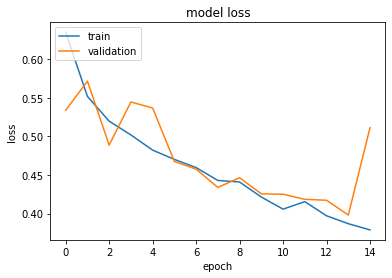

In [ ]:
plotLosses(history)

######Increase hidden neurons

In [ ]:
model = Sequential()
model.add(Dense(1000, input_dim=112*112*3, activation='sigmoid'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1000)              37633000  
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1001      
Total params: 37,634,001
Trainable params: 37,634,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train,y_train, epochs=15, batch_size=32, verbose=2, validation_data=(X_valid,y_valid))

Train on 8537 samples, validate on 3659 samples
Epoch 1/15
 - 68s - loss: 0.6360 - accuracy: 0.6508 - val_loss: 0.5621 - val_accuracy: 0.6988
Epoch 2/15
 - 68s - loss: 0.5536 - accuracy: 0.7177 - val_loss: 0.5517 - val_accuracy: 0.7344
Epoch 3/15
 - 68s - loss: 0.5342 - accuracy: 0.7306 - val_loss: 0.5231 - val_accuracy: 0.7502
Epoch 4/15
 - 68s - loss: 0.5171 - accuracy: 0.7450 - val_loss: 0.5565 - val_accuracy: 0.7349
Epoch 5/15
 - 68s - loss: 0.5079 - accuracy: 0.7558 - val_loss: 0.5190 - val_accuracy: 0.7267
Epoch 6/15
 - 68s - loss: 0.4994 - accuracy: 0.7581 - val_loss: 0.7118 - val_accuracy: 0.6056
Epoch 7/15
 - 71s - loss: 0.4911 - accuracy: 0.7665 - val_loss: 0.4813 - val_accuracy: 0.7702
Epoch 8/15
 - 68s - loss: 0.4889 - accuracy: 0.7694 - val_loss: 0.4820 - val_accuracy: 0.7647
Epoch 9/15
 - 68s - loss: 0.4810 - accuracy: 0.7737 - val_loss: 0.4726 - val_accuracy: 0.7786
Epoch 10/15
 - 68s - loss: 0.4758 - accuracy: 0.7807 - val_loss: 0.4682 - val_accuracy: 0.7879
Epoch 11/15

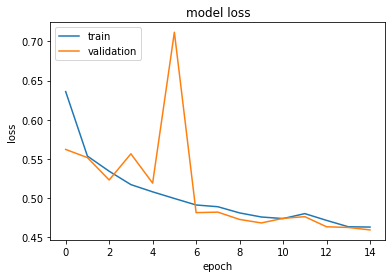

In [ ]:
plotLosses(history)

#### Increase the number of layers

In [ ]:
model = Sequential()
model.add(Dense(100, input_dim=112*112*3, activation='sigmoid'))
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               3763300   
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 3,773,501
Trainable params: 3,773,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train,y_train, epochs=15, batch_size=32, verbose=2, validation_data=(X_valid,y_valid))

Train on 8537 samples, validate on 3659 samples
Epoch 1/15
 - 9s - loss: 0.6755 - accuracy: 0.6154 - val_loss: 0.6633 - val_accuracy: 0.6636
Epoch 2/15
 - 9s - loss: 0.6440 - accuracy: 0.6933 - val_loss: 0.6359 - val_accuracy: 0.6936
Epoch 3/15
 - 9s - loss: 0.6134 - accuracy: 0.7091 - val_loss: 0.6010 - val_accuracy: 0.7199
Epoch 4/15
 - 9s - loss: 0.5840 - accuracy: 0.7179 - val_loss: 0.5754 - val_accuracy: 0.7281
Epoch 5/15
 - 10s - loss: 0.5602 - accuracy: 0.7321 - val_loss: 0.5610 - val_accuracy: 0.7158
Epoch 6/15
 - 10s - loss: 0.5421 - accuracy: 0.7393 - val_loss: 0.5371 - val_accuracy: 0.7447
Epoch 7/15
 - 10s - loss: 0.5265 - accuracy: 0.7494 - val_loss: 0.5244 - val_accuracy: 0.7439
Epoch 8/15
 - 10s - loss: 0.5158 - accuracy: 0.7518 - val_loss: 0.5376 - val_accuracy: 0.7415
Epoch 9/15
 - 10s - loss: 0.5063 - accuracy: 0.7586 - val_loss: 0.5135 - val_accuracy: 0.7543
Epoch 10/15
 - 10s - loss: 0.4983 - accuracy: 0.7608 - val_loss: 0.4992 - val_accuracy: 0.7606
Epoch 11/15
 - 

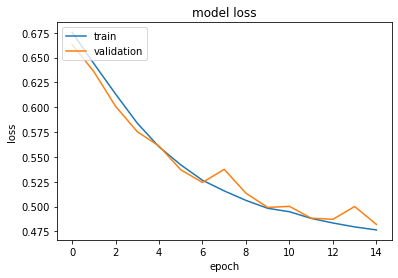

In [ ]:
plotLosses(history)

Increase the epoch, change the optimizer and also add one more layer

In [ ]:
adam = Adam(lr=1e-5)

In [ ]:
model = Sequential()
model.add(Dense(100, input_dim=112*112*3, activation='sigmoid'))
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               3763300   
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 101       
Total params: 3,783,601
Trainable params: 3,783,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train,y_train, epochs=100, batch_size=32, verbose=2, validation_data=(X_valid,y_valid))

Train on 8537 samples, validate on 3659 samples
Epoch 1/100
 - 15s - loss: 0.8033 - accuracy: 0.4978 - val_loss: 0.7574 - val_accuracy: 0.4843
Epoch 2/100
 - 15s - loss: 0.7230 - accuracy: 0.4978 - val_loss: 0.7096 - val_accuracy: 0.4843
Epoch 3/100
 - 15s - loss: 0.6990 - accuracy: 0.4978 - val_loss: 0.6965 - val_accuracy: 0.4843
Epoch 4/100
 - 15s - loss: 0.6938 - accuracy: 0.4978 - val_loss: 0.6932 - val_accuracy: 0.4843
Epoch 5/100
 - 15s - loss: 0.6926 - accuracy: 0.5278 - val_loss: 0.6921 - val_accuracy: 0.5138
Epoch 6/100
 - 15s - loss: 0.6920 - accuracy: 0.5177 - val_loss: 0.6914 - val_accuracy: 0.6125
Epoch 7/100
 - 15s - loss: 0.6912 - accuracy: 0.5650 - val_loss: 0.6906 - val_accuracy: 0.6453
Epoch 8/100
 - 15s - loss: 0.6901 - accuracy: 0.6897 - val_loss: 0.6891 - val_accuracy: 0.5731
Epoch 9/100
 - 15s - loss: 0.6882 - accuracy: 0.6454 - val_loss: 0.6870 - val_accuracy: 0.6586
Epoch 10/100
 - 15s - loss: 0.6862 - accuracy: 0.7026 - val_loss: 0.6852 - val_accuracy: 0.6953
E

In [ ]:
plotLosses(history)